**Two-dimensional histogram classification based on non-negative matrix factorization**  
Preliminary version, as a first check/ proof-of-principle.  
Need to pay more attention to definition of training and testing set(s) and hyperparameters.

In [2]:
### imports

# external modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib

# local modules
sys.path.append('../utils')
import dataframe_utils as dfu
import plot_utils as pu
import hist_utils as hu
import generate_data_2d_utils as g2u
import json_utils as jsonu
importlib.reload(dfu)
importlib.reload(pu)
importlib.reload(hu)
importlib.reload(g2u)
importlib.reload(jsonu)
sys.path.append('../src')
import DataLoader
importlib.reload(DataLoader)
sys.path.append('../src/classifiers')
import NMFClassifier
importlib.reload(NMFClassifier)
#sys.path.append('../omsapi')
#from get_oms_data import get_oms_api,get_oms_data,get_oms_response_attribute

<module 'NMFClassifier' from '/eos/home-l/llambrec/SWAN_projects/ML4DQM-DC/tutorials/../src/classifiers/NMFClassifier.py'>

raw input data shape: (627, 202, 302)
number of lumisections: 599
raw input data shape: (196, 202, 302)
number of lumisections: 185
raw input data shape: (15, 202, 302)
number of lumisections: 15


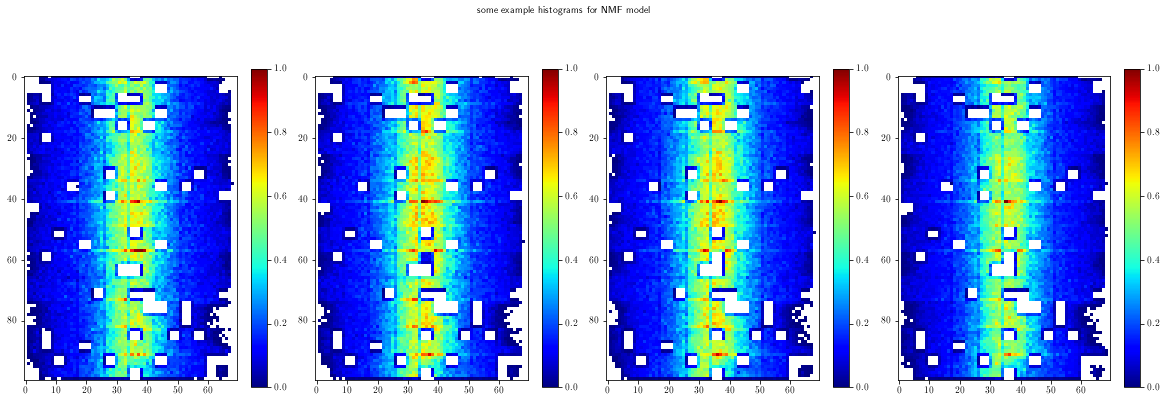

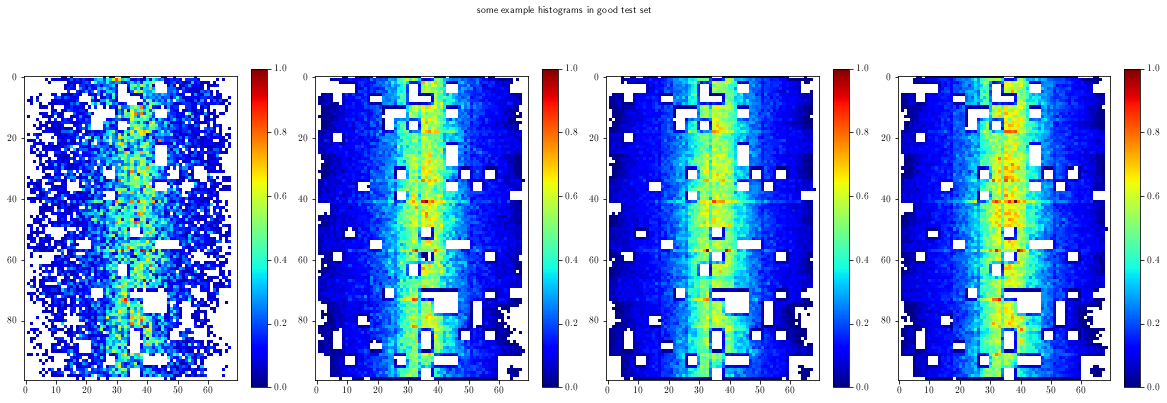

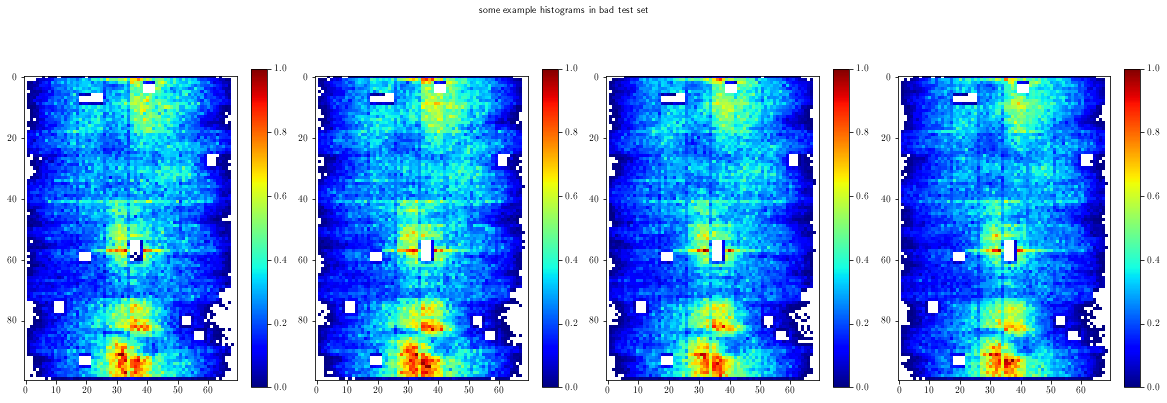

In [3]:
### load the histograms
# note: this cell assumes you have a csv file stored at the specified location,
#       containing only histograms of the specified type;
#       see the tutorial read_and_write_data for examples on how to create such files!

histname = 'clusterposition_zphi_ontrack_PXLayer_1'
datadir = '../data'
dloader = DataLoader.DataLoader()

# read training data
filename = 'DF2017B_'+histname+'_subset.csv'
histdf = dloader.get_dataframe_from_file( os.path.join(datadir, filename) )
print('raw input data shape: {}'.format( dfu.get_hist_values(histdf)[0].shape ))
histdf = dfu.select_dcson(histdf)
(hists_ref) = hu.preparedatafromdf(histdf, cropslices=[slice(1,-1,None),slice(81,221,None)], rebinningfactor=(2,2), donormalize=True, doplot=False)
_ = pu.plot_hists_2d(hists_ref[:4], ncols=4, title='some example histograms for NMF model')
print('number of lumisections: '+str(len(histdf)))

# read good test data
filename = 'DF2017B_'+histname+'_run297056.csv'
histdf = dloader.get_dataframe_from_file( os.path.join(datadir, filename) )
print('raw input data shape: {}'.format( dfu.get_hist_values(histdf)[0].shape ))
histdf = dfu.select_dcson(histdf)
(hists_good, runnbs_good, lsnbs_good) = hu.preparedatafromdf(histdf, returnrunls=True, cropslices=[slice(1,-1,None),slice(81,221,None)], rebinningfactor=(2,2), donormalize=True, doplot=False)
_ = pu.plot_hists_2d(hists_good[:4], ncols=4, title='some example histograms in good test set')
print('number of lumisections: '+str(len(histdf)))

# read bad test data
filename = 'DF2017B_'+histname+'_run297289.csv'
histdf = dloader.get_dataframe_from_file( os.path.join(datadir, filename) )
print('raw input data shape: {}'.format( dfu.get_hist_values(histdf)[0].shape ))
histdf = dfu.select_dcson(histdf)
(hists_bad, runnbs_bad, lsnbs_bad) = hu.preparedatafromdf(histdf, returnrunls=True, cropslices=[slice(1,-1,None),slice(81,221,None)], rebinningfactor=(2,2), donormalize=True, doplot=False)
_ = pu.plot_hists_2d(hists_bad[:4], ncols=4, title='some example histograms in bad test set')
print('number of lumisections: '+str(len(histdf)))

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


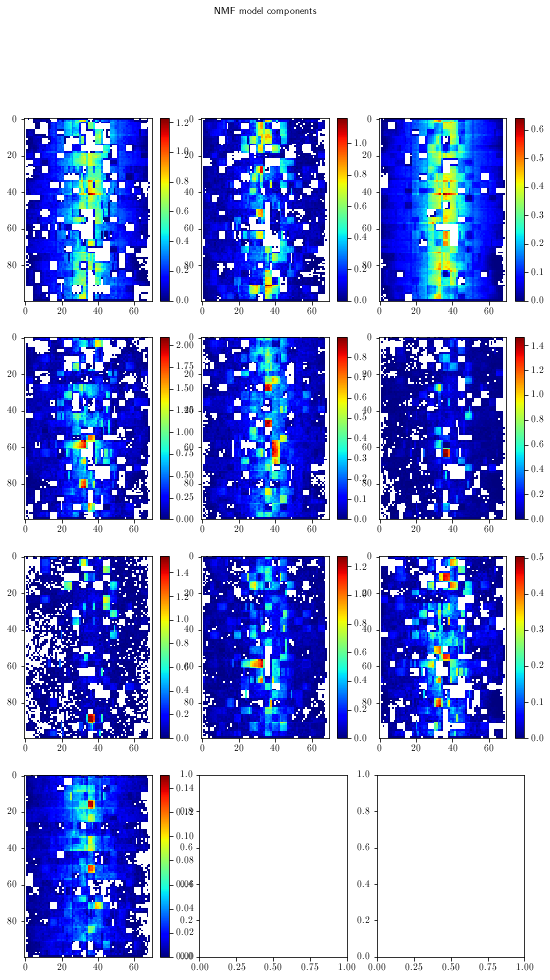

In [4]:
### build an NMF model

classifier = NMFClassifier.NMFClassifier( ncomponents=10, nmax=50 )
classifier.train( hists_ref )

In [5]:
### optionally enlarge the test set using resampling

do_resampling = True

if do_resampling:
    hists_good_ext = g2u.fourier_noise_nd(hists_good, nresamples=4, nonnegative=True, 
                     stdfactor=10., kmaxscale=0.5, ncomponents=3)
    print('shape of resampled good test set: {}'.format(hists_good_ext.shape))
    hists_bad_ext = g2u.fourier_noise_nd(hists_bad, nresamples=40, nonnegative=True, stdfactor=5., kmaxscale=0.5, ncomponents=3)
    print('shape of resampled bad test set: {}'.format(hists_bad_ext.shape))

shape of resampled good test set: (740, 100, 70)
shape of resampled bad test set: (600, 100, 70)


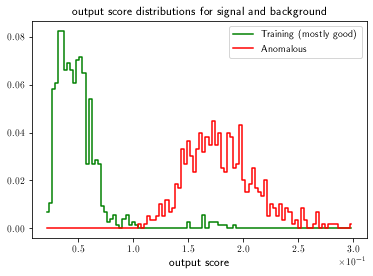

In [6]:
### perform the classification

classifier.set_nmax( 50 )

scores_good = classifier.evaluate( hists_good )
scores_bad = classifier.evaluate( hists_bad )
if do_resampling:
    scores_good_ext = classifier.evaluate( hists_good_ext )
    scores_bad_ext = classifier.evaluate( hists_bad_ext )

hists_good_appl = hists_good
hists_bad_appl = hists_bad
scores_good_appl = scores_good
scores_bad_appl = scores_bad
if do_resampling:
    hists_good_appl = hists_good_ext
    hists_bad_appl = hists_bad_ext
    scores_good_appl = scores_good_ext
    scores_bad_appl = scores_bad_ext
    
labels_good = np.zeros(len(scores_good_appl))
labels_bad = np.ones(len(scores_bad_appl))
scores = np.concatenate((scores_good_appl,scores_bad_appl))
labels = np.concatenate((labels_good,labels_bad))
_ = pu.plot_score_dist( scores, labels, nbins=100, normalize=True,
                        siglabel='Anomalous', sigcolor='r',
                        bcklabel='Training (mostly good)', bckcolor='g',
                        title='output score distributions for signal and background',
                        xaxtitle='output score', yaxtitle=None)

example histograms from good test set:


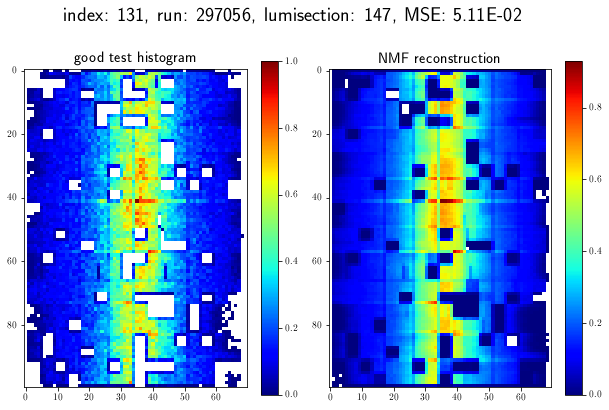

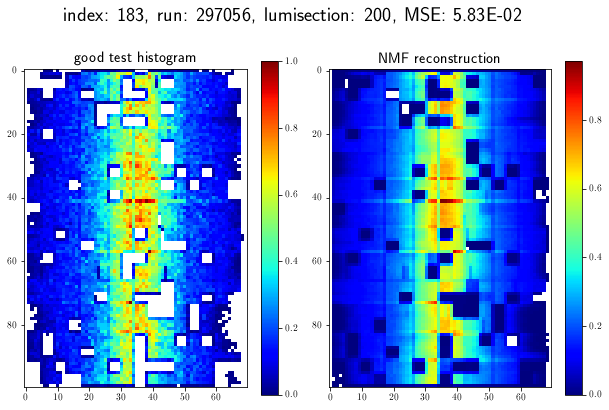

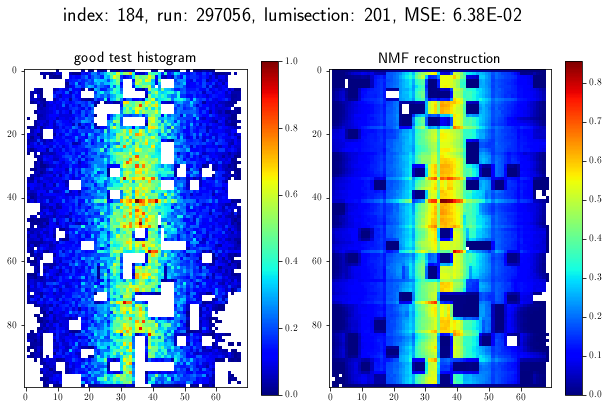

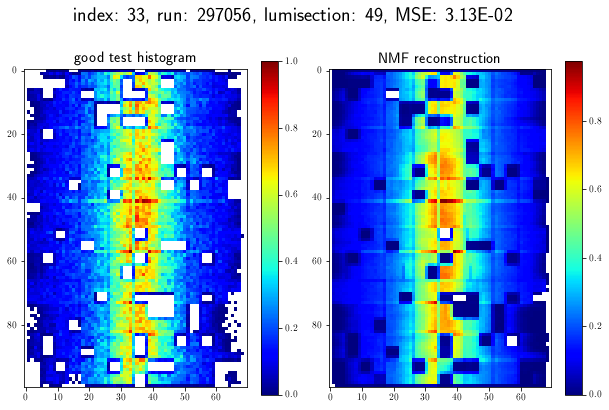

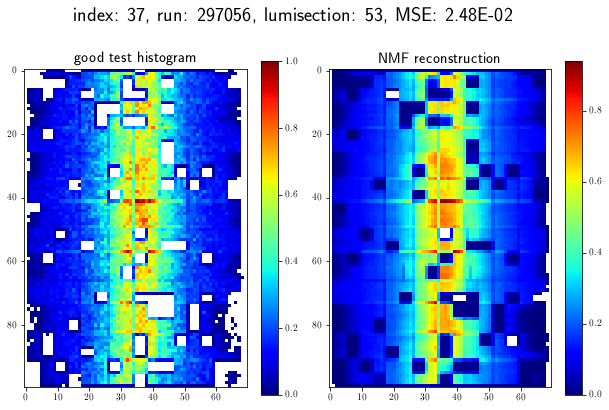

example histograms from bad test set:


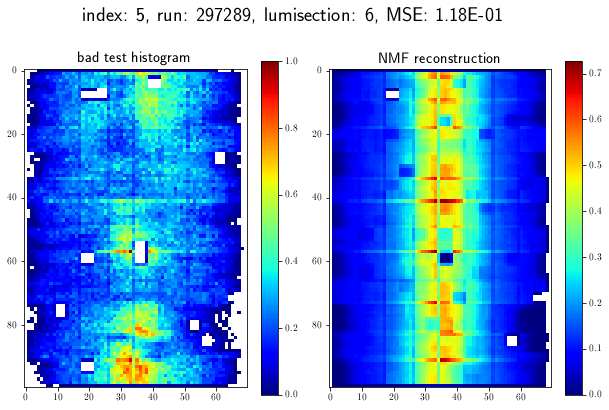

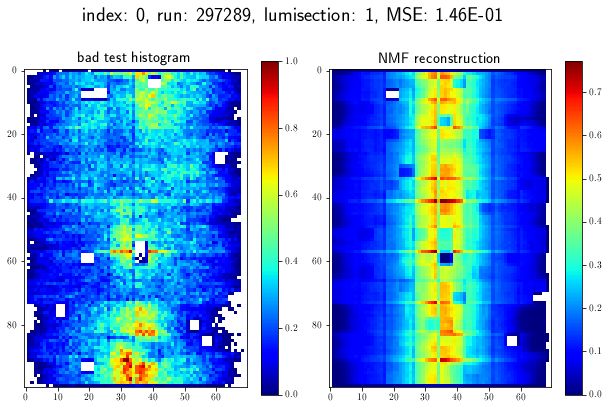

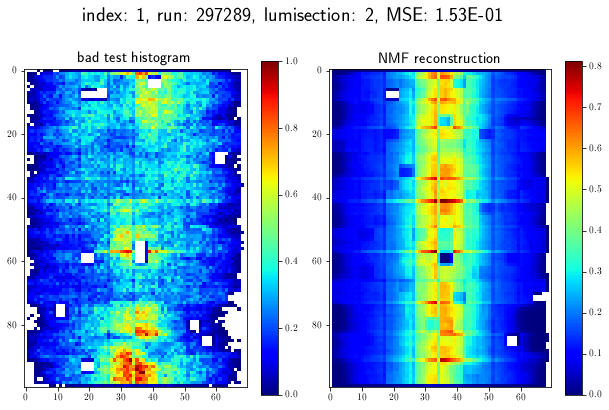

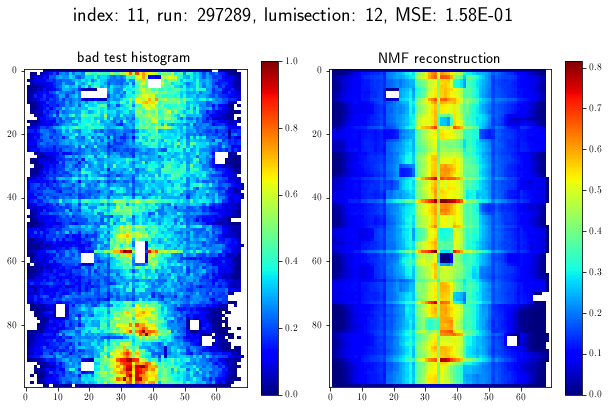

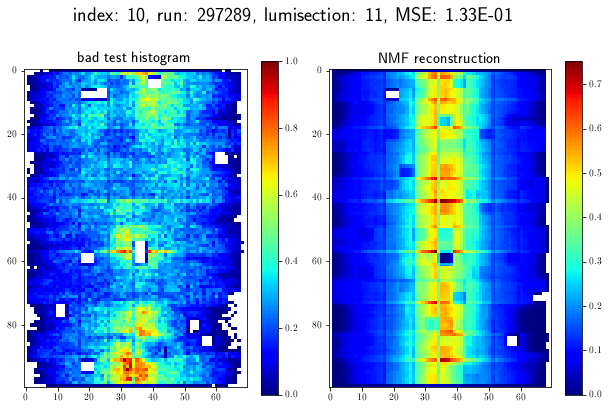

In [7]:
### check some random examples

nplot = 5

inds_good = np.random.choice(np.array(list(range(len(hists_good)))),size=nplot)
print('example histograms from good test set:')
for i in inds_good:
    histlist = [hists_good[i],classifier.reconstruct(np.array([hists_good[i]]))[0]]
    subtitles = ['good test histogram','NMF reconstruction']
    title = 'index: {}, run: {}, lumisection: {}, MSE: {:.2E}'.format(i, runnbs_good[i],lsnbs_good[i],scores_good[i])
    pu.plot_hists_2d(histlist, ncols=2, title = title, titlesize=20, subtitles=subtitles, subtitlesize=15)
plt.show()

inds_bad = np.random.choice(np.array(range(len(hists_bad))),size=nplot)
print('example histograms from bad test set:')
for i in inds_bad:
    histlist = [hists_bad[i],classifier.reconstruct(np.array([hists_bad[i]]))[0]]
    subtitles = ['bad test histogram','NMF reconstruction']
    title = 'index: {}, run: {}, lumisection: {}, MSE: {:.2E}'.format(i, runnbs_bad[i],lsnbs_bad[i],scores_bad[i])
    pu.plot_hists_2d(histlist, ncols=2, title = title, titlesize=20, subtitles=subtitles, subtitlesize=15)
plt.show()

In [ ]:
### check some examples in a given MSE range

mserange = (0.1,0.25)
test_histograms = hists_good
test_scores = scores_good
test_runnbs = runnbs_good
test_lsnbs = lsnbs_good

inds = np.where( (test_scores>mserange[0]) & (test_scores<mserange[1]) )[0]
print('{} out of {} histograms fall within this MSE range'.format(len(inds),len(test_scores)))

for indx in inds:
    hist = test_histograms[indx]
    title = 'index: {}, run: {}, lumisection: {}, MSE: {:.2E}'.format(indx, test_runnbs[indx], test_lsnbs[indx], test_scores[indx])
    pu.plot_hist_2d(hist, title = title)
    plt.show()

In [ ]:
### extra: retrieve information from OMS on pileup, lumi and/or trigger rates

omsapi = get_oms_api()
# pileup and luminosity in good test set
oms_target_run_good = 297056
ls_info_good = get_oms_data( omsapi, 'lumisections', oms_target_run_good, 
                            attributes=['lumisection_number','pileup','delivered_lumi','recorded_lumi'] )
# pileup and luminosity in bad test set
oms_target_run_bad = 297289
ls_info_bad = get_oms_data( omsapi, 'lumisections', oms_target_run_bad, 
                          attributes=['lumisection_number','pileup','delivered_lumi','recorded_lumi'])

In [ ]:
### make plots of OMS info

# plots for good run
ls_good = get_oms_response_attribute(ls_info_good,'lumisection_number')
pileup_good = get_oms_response_attribute(ls_info_good,'pileup')
lumi_del_good = get_oms_response_attribute(ls_info_good,'delivered_lumi')
lumi_rec_good = get_oms_response_attribute(ls_info_good,'recorded_lumi')
dcson_good = jsonu.isdcson( [oms_target_run_good]*len(ls_good), ls_good )
pu.plot_hists([pileup_good], colorlist=['b'], labellist=['pileup'], xlims=(ls_good[0],ls_good[-1]),
              title='pileup for good run', xaxtitle='lumisection number', yaxtitle='pileup',
              bkgcolor=dcson_good,bkgcmap='cool')
pu.plot_hists([lumi_rec_good,lumi_del_good], colorlist=['g','b'], labellist=['recorded luminosity','delivered luminosity'], xlims=(ls_good[0],ls_good[-1]),
              title='luminosity for good run', xaxtitle='lumisection number', yaxtitle='luminosity',
              bkgcolor=dcson_good,bkgcmap='cool')

ls_bad = get_oms_response_attribute(ls_info_bad,'lumisection_number')
pileup_bad = get_oms_response_attribute(ls_info_bad,'pileup')
lumi_del_bad = get_oms_response_attribute(ls_info_bad,'delivered_lumi')
lumi_rec_bad = get_oms_response_attribute(ls_info_bad,'recorded_lumi')
dcson_bad = jsonu.isdcson( [oms_target_run_bad]*len(ls_bad), ls_bad )
pu.plot_hists([pileup_bad], colorlist=['b'], labellist=['pileup'], xlims=(ls_bad[0],ls_bad[-1]),
              title='pileup for bad run', xaxtitle='lumisection number', yaxtitle='pileup',
              bkgcolor=dcson_bad,bkgcmap='cool')
pu.plot_hists([lumi_rec_bad,lumi_del_bad], colorlist=['g','b'], labellist=['recorded luminosity','delivered luminosity'], xlims=(ls_bad[0],ls_bad[-1]),
              title='luminosity for bad run', xaxtitle='lumisection number', yaxtitle='luminosity',
              bkgcolor=dcson_bad,bkgcmap='cool')

In [ ]:
### plot particular lumisections based on the OMS info above

lsnbs_tocheck = list(range(25,40))
idx_oms = [np.where(np.array(ls_good)==lsnb)[0][0] for lsnb in lsnbs_tocheck]
idx_hist = [np.where(lsnbs_good==lsnb)[0][0] for lsnb in lsnbs_tocheck]
histlist = [hists_good[i] for i in idx_hist]
subtitles = ['lumisection: {}, pileup: {}'.format(lsnbs_tocheck[i],pileup_good[idx_oms[i]]) for i in range(len(lsnbs_tocheck))]
_ = pu.plot_hists_2d(histlist, subtitles=subtitles)